In [1]:
from matplotlib import pyplot as plt
import numpy as np
from astropy.stats import sigma_clip
from scipy.signal import medfilt, correlate
import scipy.constants as cc
import os, time

In [2]:
import jwst
from jwst.datamodels import dqflags, CubeModel
                                                                                 
os.environ["CRDS_PATH"] = "/ariel/data/enzo.pascale/JWST/crds_cache"
os.environ["CRDS_SERVER_URL"] = "https://jwst-crds.stsci.edu"
print('JWST pipeline version: ', jwst.__version__)

JWST pipeline version:  1.10.2


In [3]:
def planck(wl, T):
  """ Planck function. 
    
    Parameters
    __________
      wl : 			array
				wavelength [micron]
      T : 			scalar
				Temperature [K]
				Spot temperature [K]
    Returns
    -------
      spectrum:			array
				The Planck spectrum  [W m^-2 sr^-2 micron^-1]
  """
    
  a = np.float64(1.191042768e8)
  b = np.float64(14387.7516)
  try:
    x = b/(wl*T)
    bb = a/wl**5 / (np.exp(x) - 1.0)
  except ArithmeticError:
    bb = np.zeros(np.size(wl))
  return bb

In [4]:
DeltaT = 34.44  # seconds, needs to be updatade with int_time

In [5]:
pce_file = "/ariel/data/enzo.pascale/JWST/src/observed_pce_model_fig2_giardino_2022.csv"
pce = np.loadtxt(pce_file, delimiter=',')
idx = np.argsort(pce[:, 0]) # Sort wavelength
_pce_wl_, _pce_ = pce[idx, 0], pce[idx, 1]

# Read all 4 preproccessed segments

In [6]:
segment = [1,2,3,4]
input_dir = "/ariel/data/enzo.pascale/JWST/jwst01366004001/processed"
dd = []
for seg in segment:
    input_file = "jw01366004001_04101_00001-seg{:03d}_nrs1_L1wav.fits".format(seg)
    dd.append(CubeModel(os.path.expanduser(os.path.join(input_dir, input_file))))

# Merge the 4 segments into concatenated masked arrays.

In [7]:
dq   = np.vstack( [dat.dq for dat in dd ])
data = np.ma.array(data=np.vstack( [dat.data for dat in dd ]),
                   mask = dq > 0)
varp = np.ma.array(data=np.vstack( [dat.var_poisson for dat in dd ]),
                   mask = dq > 0)
varr = np.ma.array(data=np.vstack( [dat.var_rnoise for dat in dd ]),
                   mask = dq > 0)
wavelength = dd[0].wavelength
n1, n2 = wavelength.shape
wavelength = wavelength[n1//2]

# Wavelength extrapolation
The wavelength solution array has NaNs where there is no signal. Rustamkulov (2023) use only columns from 14 to 495. Here, I prefer to characterise the noise across the whole array, without masking any particular region of the focal plane. For this, I extrapolate the wavelength solution across those deltector columns that have any.  

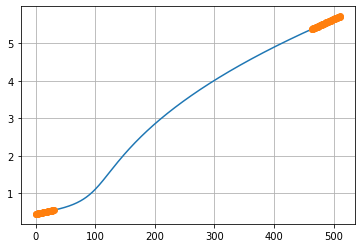

In [8]:
from scipy.interpolate import interp1d

mask = np.isfinite(wavelength)
x = np.linspace(0,1,wavelength.size)
pix = np.arange(wavelength.size)

par = np.polyfit(x[mask], wavelength[mask], 4)
model = np.poly1d(par)
model = interp1d(x[mask], wavelength[mask], bounds_error=False, fill_value="extrapolate")
wavelength[~mask] = model(x[~mask])
plt.plot(pix[mask], wavelength[mask], '-')
plt.plot(pix[~mask], wavelength[~mask], 'o', )
plt.grid()

# Bin light curves
The following estimates the wavelength dependent and the white light curves.
The wavelength binning has yet to be optimised. T-shirt use 4x14 pixels/spectral bin in Rustamkulov (2023).

In [9]:
n1, n2, n3 = data.shape
rAper = 7
Nbin = 4

rest = wavelength.size % 2
slc_valid = slice(0, n3-rest)
dq = dq[..., slc_valid]
data = data[..., slc_valid]
varp = varp[..., slc_valid]
varr = varr[..., slc_valid]
wavelength = wavelength[slc_valid]

yc = n2//2 - 1
clc = data[:, yc-rAper:yc+rAper+1, :].reshape(n1, 2*rAper+1, -1, Nbin).sum(axis=3).sum(axis=1)
var_poisson = varp[:, yc-rAper:yc+rAper+1, :].reshape(n1, 2*rAper+1, -1, Nbin).sum(axis=3).sum(axis=1)
var_rnoise  = varr[:, yc-rAper:yc+rAper+1, :].reshape(n1, 2*rAper+1, -1, Nbin).sum(axis=3).sum(axis=1)
wlc = clc[:, :].sum(axis=-1)
wl = wavelength.reshape(-1, Nbin).mean(axis=-1)
pce = np.interp(wl, _pce_wl_, _pce_)
tt = np.arange(clc.shape[0])*DeltaT/3600
Eph = cc.h*cc.c/cc.e/(wl*1e-6)

G = 1 + 0.72*(Eph - 0.65)
G[Eph < 0.65] = 1
print(G)

[2.5043848 2.4472668 2.3933642 2.3424125 2.2941759 2.2484431 2.2050238
 2.1637473 2.12396   2.0836434 2.0423818 1.9995811 1.9562817 1.9119326
 1.866499  1.8199649 1.7723436 1.7236583 1.6739824 1.6234388 1.5722402
 1.520673  1.4691153 1.4180771 1.3681484 1.3199638 1.2741473 1.231214
 1.1915181 1.155214  1.1222777 1.0925475 1.0657849 1.0417098 1.0200404
 1.000488  1.        1.        1.        1.        1.        1.
 1.        1.        1.        1.        1.        1.        1.
 1.        1.        1.        1.        1.        1.        1.
 1.        1.        1.        1.        1.        1.        1.
 1.        1.        1.        1.        1.        1.        1.
 1.        1.        1.        1.        1.        1.        1.
 1.        1.        1.        1.        1.        1.        1.
 1.        1.        1.        1.        1.        1.        1.
 1.        1.        1.        1.        1.        1.        1.
 1.        1.        1.        1.        1.        1.        1.
 1.   

# Rough mid-transit calibration

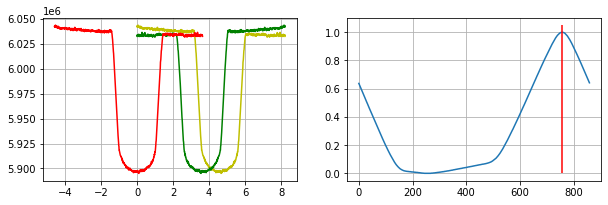

In [10]:
fig, (ax0, ax1) = plt.subplots(1,2, figsize=(10,3))

ax0.plot(tt, wlc, 'y')
ax0.plot(tt, wlc[::-1], 'g')

# Compute correlation
cor = np.zeros_like(wlc)
for k in range(cor.size):
    cor[k] = np.sum(wlc[::-1]*np.roll(wlc, k))

cor -= cor.min(); cor /= cor.max()
i0 = tt.size-np.argmax(cor)//2 - 2
ax1.plot(cor)
ax1.vlines(np.argmax(cor), 0,1.05, color='r')
t0 = tt[i0]

tt -= t0
ax0.plot(tt, wlc, 'r')
ax0.grid()
ax1.grid()


# Baseline drift removal
There is a drift in the baselines, and the drift is different for different spectral bins. The origin of this drift is currently **unkown**.

A polynomial is fit to the OOT portion of each spectral timeline, and divided out.

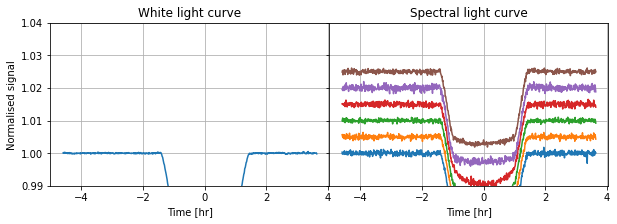

In [11]:
from numpy.polynomial import Polynomial
fig, (ax0, ax1) = plt.subplots(1,2, figsize=(10,3), sharey=True)
fig.subplots_adjust(wspace=0)

oot_idx = np.logical_or( tt < -1.5, tt > 1.5 )
oot_idx = np.logical_or( tt < -2, tt > 2 )
#oot_idx = np.logical_or(np.logical_and( tt>-3.5, tt < -1.5),
#                        np.logical_and( tt>1.5, tt < 3))

model = np.zeros_like(clc)

for k in range(clc.shape[-1]):
    par = np.ma.polyfit(tt[oot_idx], clc[oot_idx, k], 5)
    p = np.poly1d(par)
    model[:, k] = p(tt)

clcnorm = clc/model
varPnorm = var_poisson/model**2
varNnorm = var_rnoise/model**2

weights = np.ma.median(model, axis=0)
wlc = np.ma.average(clcnorm[:, 3:-3], weights=weights[3:-3], axis=-1)

ax0.plot(tt, wlc)
ax0.set_title('White light curve')
ax0.set_xlabel('Time [hr]')
ax0.set_ylabel('Normalised signal')
ax0.grid()


ax1.plot(tt, clcnorm[:, 14])
ax1.plot(tt, clcnorm[:, 15]+0.005*1)
ax1.plot(tt, clcnorm[:, 16]+0.005*2)
ax1.plot(tt, clcnorm[:, 17]+0.005*3)
ax1.plot(tt, clcnorm[:, 50]+0.005*4)
ax1.plot(tt, clcnorm[:, 41]+0.005*5)
#ax1.plot(tt, clcnorm[:, 35:36].mean(axis=-1)+0.005*3)
ax1.set_ylim(0.990, 1.040)
ax1.set_title('Spectral light curve')
ax1.set_xlabel('Time [hr]')
ax1.grid()


# Noise comparison

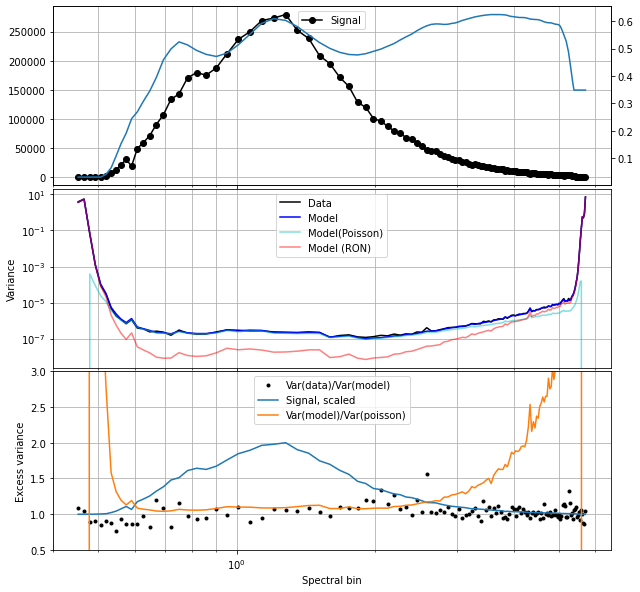

In [16]:
fig, (ax0, ax1, ax2) = plt.subplots(3,1, figsize=(10,10), sharex=True)
fig.subplots_adjust(hspace=0.02)


oot_idx = np.logical_or( tt < -1.5, tt > 1.5 )
#oot_idx = np.logical_or( tt > 2, tt > 2 )
#oot_idx = np.logical_and( tt > -4, tt < -2 )
#oot_idx = np.logical_and( tt > 2, tt < 4 )

slc_w = slice(0,None)

mean = model[oot_idx, slc_w].mean(axis=0)
vard  =  clcnorm[oot_idx, slc_w].var(axis=0, ddof=1)
varp   = varPnorm[oot_idx, slc_w].mean(axis=0)*G
varn   = varNnorm[oot_idx, slc_w].mean(axis=0)

stdd = 1e6*np.sqrt(vard)
stdp = 1e6*np.sqrt(np.abs(varp))
stdn = 1e6*np.sqrt(varn)

ax0.plot(wl, mean, '-ok', label='Signal')
ax0t = ax0.twinx()
ax0t.plot(wl, pce)

ax0t.plot()
ax1.plot(wl, vard, '-k', label='Data')
ax1.plot(wl, varp+varn, '-b', label='Model')
ax1.plot(wl, varp, '-c', alpha=0.5, label='Model(Poisson)')
ax1.plot(wl, varn, '-r', alpha=0.5, label='Model (RON)')
ax1.set_yscale('log')
ax1.set_ylabel('Variance')

y = vard/(varp+varn)
ax2.plot(wl, y, '.k', label='Var(data)/Var(model)')
ax2.plot(wl, mean/mean.max()+1, '-', label='Signal, scaled')
ax2.plot(wl, 1+varn/varp, label='Var(model)/Var(poisson)')
#ax2t = ax2.twinx()

ax2.set_ylim(0.5,3)
ax2.set_xlabel('Spectral bin')
ax2.set_ylabel('Excess variance')


for ax in (ax0, ax1, ax2):
    ax.grid(which='both')
    ax.legend(loc='upper center')
    ax.set_xscale('log')
    


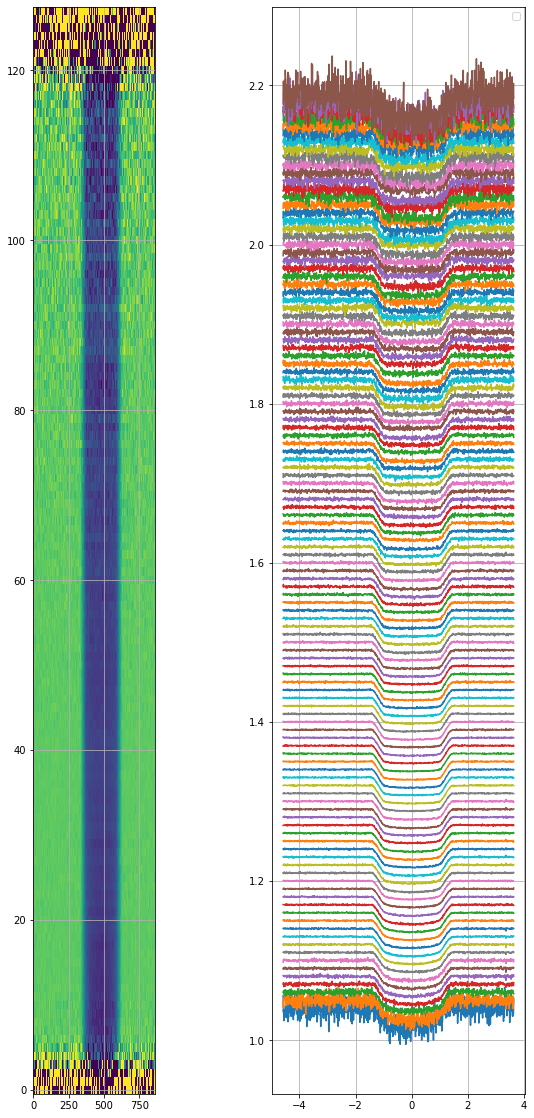

In [17]:
fig, (ax0, ax1) = plt.subplots(1,2,figsize=(10,20))

ax0.imshow(clcnorm.T, aspect=60, vmin=0.97, vmax=1.01, interpolation='None', origin='lower')

for k in range(16//Nbin, 480//Nbin):
    ax1.plot(tt, clcnorm[:, k]+k/100)



ax1.legend()
ax0.grid()
ax1.grid()
    
    